# <center> Costa Rican Household Poverty Level Prediction </center>

---

# Content
- [Problem Statement](#Problem-Statement)
- [Main Objective](#Main-Objective)
- [Data Exploratory](#Data-Exploratory)
- [Data Munging](#Data-Munging)

# Problem Statement

---

Many social programs have a hard time making sure the right people are given enough aid. It’s especially tricky when a program focuses on the poorest segment of the population. The world’s poorest typically can’t provide the necessary income and expense records to prove that they qualify.

In Latin America, one popular method uses an algorithm to verify income qualification. It’s called the Proxy Means Test (or PMT). With PMT, agencies use a model that considers a family’s observable household attributes like the material of their walls and ceiling, or the assets found in the home to classify them and predict their level of need.

While this is an improvement, accuracy remains a problem as the region’s population grows and poverty declines.

# Main Objective

---

We strive to improve the accuracy of the predicting households' level of need by proposing a using a new model - Linear Regression. With the given variables in the dataset, we set out to predict poverty on a `household level`.

# Dataset Information

---

Core Data fields

    Id - a unique identifier for each row.
    Target - the target is an ordinal variable indicating groups of income levels. 
        1 = extreme poverty 
        2 = moderate poverty 
        3 = vulnerable households 
        4 = non vulnerable households
    idhogar - this is a unique identifier for each household. This can be used to create household-wide features, etc. 

All rows in a given household will have a matching value for this identifier.
parentesco1 - indicates if this person is the head of the household.
This data contains 142 total columns.

All other data fields [can be found here](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data).


# Data Munging

---

Importing libraries and set graph style

In [10]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

#### Reading training dataset

In [11]:
train = pd.read_csv("train.csv")

We first find out the data types for each column

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


This tells us there are 130 integer columns, 8 float (numeric) columns, and 5 object columns. The object columns might pose an issue because they cannot be fed directly into a machine learning model.

Lets take a look at the 5  columns that are `object` datatypes

In [18]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


We will not be including the individual id and household id in our machine learning model, so lets investigate the other 3 columns that we may put into the machine learning model.

 According to the documentation for these columns:

* `dependency`: Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
* `edjefe`: years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
* `edjefa`: years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

For now, lets dive deeper into the 3 columns to see what values they contain.
For `dependency` :

In [27]:
train.select_dtypes('object')['dependency'].value_counts()

yes          2192
no           1747
.5           1497
2             730
1.5           713
.33333334     598
.66666669     487
8             378
.25           260
3             236
4             100
.75            98
.2             90
1.3333334      84
.40000001      84
2.5            77
5              24
1.25           18
3.5            18
.80000001      18
2.25           13
.71428573      12
.22222222      11
1.75           11
1.2            11
.83333331      11
.2857143        9
.60000002       8
1.6666666       8
6               7
.16666667       7
Name: dependency, dtype: int64

In [28]:
train.select_dtypes('object')['edjefe'].value_counts()

no     3762
6      1845
11      751
9       486
3       307
15      285
8       257
7       234
5       222
14      208
17      202
2       194
4       137
16      134
yes     123
12      113
10      111
13      103
21       43
18       19
19       14
20        7
Name: edjefe, dtype: int64

In [29]:
train.select_dtypes('object')['edjefa'].value_counts()

no     6230
6       947
11      399
9       237
8       217
15      188
7       179
5       176
3       152
4       136
14      120
16      113
10       96
2        84
17       76
12       72
yes      69
13       52
21        5
19        4
18        3
20        2
Name: edjefa, dtype: int64

As we scan through, realise that all values are float or integer except for string of `yes` and `no`

#### Since they mentioned that `yes` = 1, `no` = 0 - we will replace them with 1 and 0 respectively

In [31]:
mapping = {"yes": 1, "no": 0}

train['dependency'] = train['dependency'].replace(mapping).astype(np.float64)
train['edjefa'] = train['edjefa'].replace(mapping).astype(np.int64)
train['edjefe'] = train['edjefe'].replace(mapping).astype(np.int64)

train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(9), int64(132), object(2)
memory usage: 10.4+ MB


ValueError: num must be 1 <= num <= 8, not 9

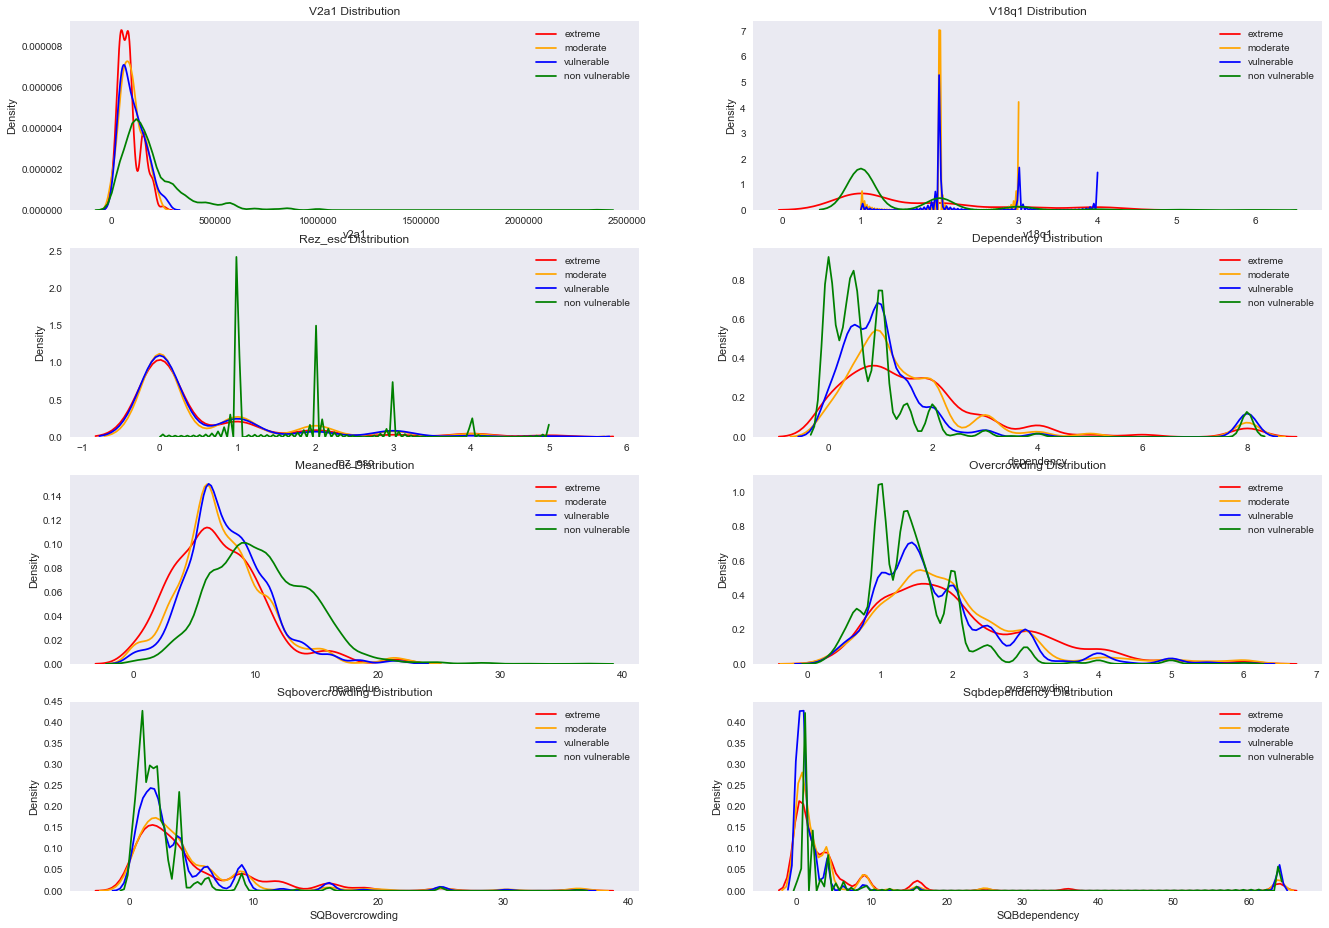

In [32]:
from collections import OrderedDict

plt.figure(figsize = (20, 16))
plt.style.use('seaborn-dark')
# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

# Iterate through the float columns
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

Lets take a look if there are any duplicates (households should be unique). <br>
As shown below, the rule stands true - every households only has one household head.

In [ ]:
train['idhogar'].value_counts()[train['idhogar'].value_counts() > 1]

Which columns contains null value?

In [ ]:
train.isnull().sum()[train.isnull().sum() > 0]

Significance of each columns:
    
    v2a1, monthly rent
    v18q1, number of tablets household owns
    rez_esc, Years behind in school
    meaneduc, average years of education for adults (18+)
    SQBmeaned, square of the mean years of education of adults (>=18) in the household


In [ ]:
len(train)

Since they mentioned that we should only choose the `household head`, we remove rows(individuals) that are not the `household head`

Household_leaders:
`parentesco1, =1 if household head`